In [1]:
from function import *
from data_preparation import *
from evaluation import *

from openpyxl import Workbook
import pandas as pd
import numpy as np
import operator

from rdkit import Chem
from rdkit.Chem import AllChem

# Pre-prepare Data (Data Transformation)

In [2]:
# transform_data(output_file_name='../dataset/keck_complete.csv')

# Analysis

In [3]:
complete_df = pd.read_csv('../dataset/keck_complete.csv')

print complete_df.dtypes

Molecule                   object
SMILES                     object
Fingerprints               object
Keck_Pria_AS_Retest         int64
Keck_Pria_FP_data           int64
Keck_Pria_Continuous      float64
Keck_RMI_cdd              float64
FP counts % inhibition    float64
dtype: object


In [4]:
cnt_pria_retest = 0
cnt_pria_fp = 0
cnt_rmi_cdd = 0

cnt_dict = {}
for ix, row in complete_df.iterrows():
    cnt = 0
    if row['Keck_Pria_AS_Retest'] == 1:
        cnt_pria_retest += 1
        cnt += 1
    if row['Keck_Pria_FP_data'] == 1:
        cnt_pria_fp += 1
        cnt += 1
    if row['Keck_RMI_cdd'] == 1:
        cnt_rmi_cdd += 1
        cnt += 1
    if cnt not in cnt_dict.keys():
        cnt_dict[cnt] = 0
    cnt_dict[cnt] += 1

print 'pria retest active: {}\tpria fp active: {}\trmi cdd active: {}'.format(cnt_pria_retest, cnt_pria_fp, cnt_rmi_cdd)
print cnt_dict


print
analysis(complete_df)

pria retest active: 79	pria fp active: 24	rmi cdd active: 230
{0: 72094, 1: 325, 2: 4}

retest: 0, fp: 0, rmi: 0 	--- 49489
retest: 0, fp: 0, rmi: nan 	--- 22605
retest: 0, fp: 1, rmi: 0 	--- 19
retest: 0, fp: 1, rmi: 1 	--- 3
retest: 1, fp: 0, rmi: 0 	--- 58
retest: 1, fp: 0, rmi: nan 	--- 20
retest: 0, fp: 1, rmi: nan 	--- 1
retest: 0, fp: 0, rmi: 1 	--- 227
retest: 1, fp: 1, rmi: nan 	--- 1


# Split data into k-fold

In [5]:
k = 3
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

In [6]:
k = 4
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

In [7]:
k = 5
directory = '../dataset/fixed_dataset/fold_{}/'.format(k)
file_list = []
for i in range(k):
    file_list.append('file_{}.csv'.format(i))
# greedy_multi_splitting(complete_df, k, directory=directory, file_list=file_list)

# Merge data from splitting folds to form training and testing

In [8]:
dtype_list = {'Molecule': np.str,
              'SMILES':np.str,
              'Fingerprints': np.str,
              'Keck_Pria_AS_Retest': np.int64,
              'Keck_Pria_FP_data': np.int64,
              'Keck_Pria_Continuous': np.float64,
              'Keck_RMI_cdd': np.float64}
output_file_list = [directory + f_ for f_ in file_list]
print output_file_list[:4]
train_pd = read_merged_data(output_file_list[:4])
print output_file_list[4]
test_pd = read_merged_data([output_file_list[4]])

['../dataset/fixed_dataset/fold_5/file_0.csv', '../dataset/fixed_dataset/fold_5/file_1.csv', '../dataset/fixed_dataset/fold_5/file_2.csv', '../dataset/fixed_dataset/fold_5/file_3.csv']
../dataset/fixed_dataset/fold_5/file_4.csv


In [9]:
print 'This is training set'
analysis(train_pd)
print
print 'This is test set'
analysis(test_pd)

This is training set
retest: 0, fp: 0, rmi: 0 	--- 39591
retest: 0, fp: 0, rmi: nan 	--- 18084
retest: 1, fp: 0, rmi: nan 	--- 16
retest: 0, fp: 1, rmi: 1 	--- 2
retest: 1, fp: 0, rmi: 0 	--- 47
retest: 0, fp: 0, rmi: 1 	--- 181
retest: 0, fp: 1, rmi: nan 	--- 1
retest: 0, fp: 1, rmi: 0 	--- 15

This is test set
retest: 0, fp: 0, rmi: 0 	--- 9898
retest: 0, fp: 0, rmi: nan 	--- 4521
retest: 1, fp: 0, rmi: nan 	--- 4
retest: 0, fp: 1, rmi: 1 	--- 1
retest: 1, fp: 0, rmi: 0 	--- 11
retest: 0, fp: 0, rmi: 1 	--- 46
retest: 0, fp: 1, rmi: 0 	--- 4
retest: 1, fp: 1, rmi: nan 	--- 1


# Test feature- and label- extraction

In [10]:
print train_pd.dtypes

X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_AS_Retest', 'Keck_Pria_FP_data'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_AS_Retest', 'Keck_Pria_FP_data'])

Molecule                   object
SMILES                     object
Fingerprints               object
Keck_Pria_AS_Retest         int64
Keck_Pria_FP_data           int64
Keck_Pria_Continuous      float64
Keck_RMI_cdd              float64
FP counts % inhibition    float64
dtype: object
(57937, 2)
(14486, 2)


# Test Single Classification with Simple NN

## Test Label 'Keck_Pria_AS_Retest'

In [11]:
from sklearn.cross_validation import StratifiedShuffleSplit

X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_AS_Retest'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_AS_Retest'])
cross_validation_split = StratifiedShuffleSplit(y_train, 1, test_size=0.15, random_state=1)
for t_index, val_index in cross_validation_split:
    X_t, X_val = X_train[t_index], X_train[val_index]
    y_t, y_val = y_train[t_index], y_train[val_index]
print 'done data preparation'

(57937, 1)
(14486, 1)
done data preparation


In [12]:
print X_t.shape
print y_t.shape
print
print X_val.shape
print y_val.shape
print
print X_test.shape
print y_test.shape

(49246, 1024)
(49246, 1)

(8691, 1024)
(8691, 1)

(14486, 1024)
(14486, 1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pr curve  (17356, 3)
plot 1
pr curve  (17366, 3)
plot 2
pr curve  (97938, 3)
plot 3
Epoch 1/1
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.762521 ---- ROC Val: 0.627480

pr curve  (97938, 3)
plot 4
train precision: 0.307948754443
train roc: 0.762521420225
pr curve  (17366, 3)
plot 5
validation precision: 0.307887837645
validation roc: 0.627479587397
pr curve  (28921, 3)
plot 6
test precision: 0.307956724616
test roc: 0.51579561161
ratio: 0.02, EF: 3.125,	active: 16.0
ratio: 0.01, EF: 6.25,	active: 16.0
ratio: 0.0015, EF: 0.0,	active: 16.0
ratio: 0.001, EF: 0.0,	active: 16.0
duration is  904.734025002


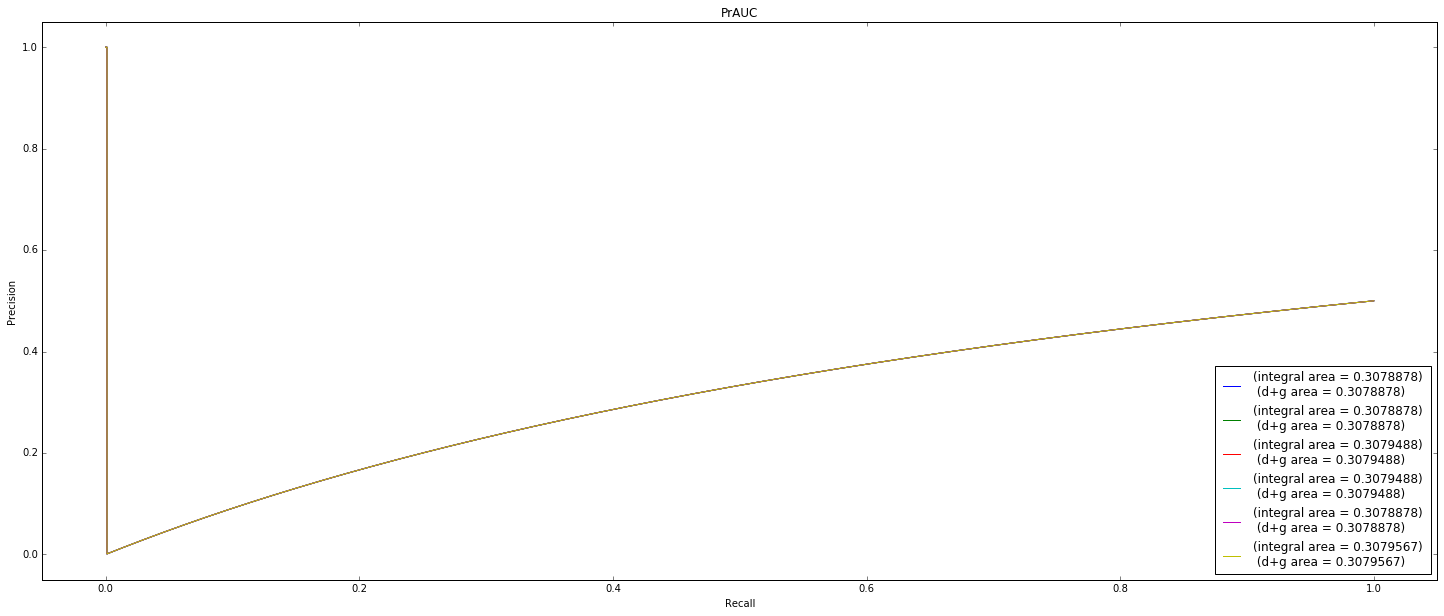

In [15]:
%load_ext autoreload
%autoreload 2
from single_task import *
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (25.0, 10.0)


config_json_file = '../json/classification.json'
PMTNN_weight_file = 'temp.h5'
task = single_task(config_json_file=config_json_file)
start_time = time.time()
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

duration = time.time() - start_time
print('duration is '),
print(duration)

In [13]:
%load_ext autoreload
%autoreload 2
from single_task import *
import time

config_json_file = '../json/classification.json'
PMTNN_weight_file = 'temp.h5'
task = single_task(config_json_file=config_json_file)
start_time = time.time()
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

duration = time.time() - start_time
print('duration is '),
print(duration)

Using Theano backend.
Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN 4004)


Epoch 1/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.714818 ---- ROC Val: 0.666551

Epoch 2/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.761094 ---- ROC Val: 0.588395

Epoch 3/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.877293 ---- ROC Val: 0.707556

Epoch 4/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.924797 ---- ROC Val: 0.722721

Epoch 5/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.962055 ---- ROC Val: 0.713673

Epoch 6/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.977653 ---- ROC Val: 0.739307

Epoch 7/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.992100 ---- ROC Val: 0.766349

Epoch 8/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.994453 ---- ROC Val: 0.771507

Epoch 9/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.997767 ---- ROC Val: 0.752412

E

In [14]:
%load_ext autoreload
%autoreload 2
from single_task import *
import time

config_json_file = '../json/classification.json'
PMTNN_weight_file = 'temp.h5'
task = single_task(config_json_file=config_json_file)
start_time = time.time()
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

duration = time.time() - start_time
print('duration is '),
print(duration)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.758501 ---- ROC Val: 0.652064

Epoch 2/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.874236 ---- ROC Val: 0.683829

Epoch 3/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.933676 ---- ROC Val: 0.717781

Epoch 4/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.939492 ---- ROC Val: 0.722005

Epoch 5/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.945847 ---- ROC Val: 0.712470

Epoch 6/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.965544 ---- ROC Val: 0.723963

Epoch 7/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.977030 ---- ROC Val: 0.696063

Epoch 8/200
Precision Train: 0.307949 ---- Precision Val: 0.307888
ROC Train: 0.981356 ---- ROC Val: 0.757199

Epoch 9/200
Precision Tr

In [15]:
%load_ext autoreload
%autoreload 2
from single_task import *
import time

config_json_file = '../json/classification.json'
PMTNN_weight_file = 'temp.h5'
task = single_task(config_json_file=config_json_file)
start_time = time.time()
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

duration = time.time() - start_time
print('duration is '),
print(duration)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/200
Precision Train: 0.003951 ---- Precision Val: 0.001187
ROC Train: 0.704973 ---- ROC Val: 0.527208

Epoch 2/200
Precision Train: 0.006603 ---- Precision Val: 0.001323
ROC Train: 0.792084 ---- ROC Val: 0.559139

Epoch 3/200
Precision Train: 0.040294 ---- Precision Val: 0.003437
ROC Train: 0.895631 ---- ROC Val: 0.653574

Epoch 4/200
Precision Train: 0.065289 ---- Precision Val: 0.010492
ROC Train: 0.899158 ---- ROC Val: 0.712304

Epoch 5/200
Precision Train: 0.115930 ---- Precision Val: 0.013899
ROC Train: 0.923898 ---- ROC Val: 0.733907

Epoch 6/200
Precision Train: 0.349229 ---- Precision Val: 0.032995
ROC Train: 0.964713 ---- ROC Val: 0.669162

Epoch 7/200
Precision Train: 0.422523 ---- Precision Val: 0.153172
ROC Train: 0.970782 ---- ROC Val: 0.789501

Epoch 8/200
Precision Train: 0.505769 ---- Precision Val: 0.038503
ROC Train: 0.976476 ---- ROC Val: 0.708042

Epoch 9/200
Precision Tr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%load_ext autoreload
%autoreload 2
from single_task import *
import time

config_json_file = '../json/classification.json'
PMTNN_weight_file = 'temp.h5'
task = single_task(config_json_file=config_json_file)
start_time = time.time()
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

duration = time.time() - start_time
print('duration is '),
print(duration)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/200
Precision Train: 0.004161 ---- Precision Val: 0.004566
ROC Train: 0.740204 ---- ROC Val: 0.498183

Epoch 2/200
Precision Train: 0.014270 ---- Precision Val: 0.002793
ROC Train: 0.838587 ---- ROC Val: 0.497184

Epoch 3/200
Precision Train: 0.066418 ---- Precision Val: 0.003877
ROC Train: 0.910245 ---- ROC Val: 0.744874

Epoch 4/200
Precision Train: 0.203834 ---- Precision Val: 0.013953
ROC Train: 0.931942 ---- ROC Val: 0.733996

Epoch 5/200
Precision Train: 0.394468 ---- Precision Val: 0.025027
ROC Train: 0.980352 ---- ROC Val: 0.781988

Epoch 6/200
Precision Train: 0.370703 ---- Precision Val: 0.023800
ROC Train: 0.973651 ---- ROC Val: 0.811769

Epoch 7/200
Precision Train: 0.410308 ---- Precision Val: 0.015331
ROC Train: 0.987678 ---- ROC Val: 0.781835

Epoch 8/200
Precision Train: 0.630388 ---- Precision Val: 0.043425
ROC Train: 0.989747 ---- ROC Val: 0.827062

Epoch 9/200
Precision Tr

In [12]:
# old PR
from single_task import *

config_json_file = '../json/classification.json'
PMTNN_weight_file = 'temp.h5'
task = single_task(config_json_file=config_json_file)
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

Using Theano backend.
Using gpu device 0: Tesla K40m (CNMeM is disabled, CuDNN 4004)


Epoch 1/200
Precision Train: 0.002749 ---- Precision Val: 0.001608
AUC Train: 0.703939 ---- AUC Val: 0.592695

Epoch 2/200
Precision Train: 0.009402 ---- Precision Val: 0.007995
AUC Train: 0.832994 ---- AUC Val: 0.774949

Epoch 3/200
Precision Train: 0.094923 ---- Precision Val: 0.004849
AUC Train: 0.914104 ---- AUC Val: 0.881274

Epoch 4/200
Precision Train: 0.136801 ---- Precision Val: 0.006231
AUC Train: 0.944263 ---- AUC Val: 0.814866

Epoch 5/200
Precision Train: 0.278015 ---- Precision Val: 0.005896
AUC Train: 0.974068 ---- AUC Val: 0.841690

Epoch 6/200
Precision Train: 0.415415 ---- Precision Val: 0.010034
AUC Train: 0.984195 ---- AUC Val: 0.928230

Epoch 7/200
Precision Train: 0.464976 ---- Precision Val: 0.004612
AUC Train: 0.989288 ---- AUC Val: 0.828368

Epoch 8/200
Precision Train: 0.565419 ---- Precision Val: 0.005320
AUC Train: 0.988519 ---- AUC Val: 0.749686

Epoch 9/200
Precision Train: 0.647045 ---- Precision Val: 0.003907
AUC Train: 0.990928 ---- AUC Val: 0.801390

E

In [12]:
def precision_auc_single(actual, predicted, mode='auc.integral'):
    
    prroc = rpackages.importr('PRROC')
    x = robjects.FloatVector(actual)
    y = robjects.FloatVector(predicted)
    print len(x)
    print len(y)
    pr = prroc.pr_curve(x, y, curve=True)
    try:
        prec_auc = pr.rx2(mode)[0]
    except:
        print 'Error: Wrong mode value. Should be either auc.integral or auc.davis.goadrich.'
    
    pr_curve = np.array(pr[3])
    plt.clf()
    plt.plot(pr_curve[:,0], pr_curve[:,1], label='(integral area = %0.7f) \n (d+g area = %0.7f)' % (pr[1][0], pr[2][0]))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PrAUC')
    plt.legend(loc="lower right")

    plt.savefig('../plottings/running_epoch.png')
    
    print 'save'
    
    return prec_auc


# Plot EF and EF-Max graph

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (25.0, 10.0)

In [ ]:
def plot_EF_score_with_existing_model(X_test, y_test, file_path, EF_ratio=0.1):
    model = task.setup_model()
    model.load_weights(file_path)
    y_pred_on_test = model.predict(X_test)
    EF_ratio_list = [0.1, 0.5, 1, 2, 3, 4, 5, 10, 15, 20]
    EF_ratio_list = np.array(EF_ratio_list) / 100.0
    
    ef_values = []
    ef_max_values = []
    for EF_ratio in EF_ratio_list:
        n_actives, ef, ef_max = enrichment_factor_single(y_test, y_pred_on_test, EF_ratio)
        ef_values.append(ef)
        ef_max_values.append(ef_max)
    
    x_axis = EF_ratio_list
    y_axis = np.array(ef_values)
    plt.plot(x_axis, y_axis)
    
    x_axis = EF_ratio_list
    y_axis = np.array(ef_max_values)
    plt.plot(x_axis, y_axis)
    
    plt.legend(['EF', 'EF Max'])
    
    plt.xticks(EF_ratio_list, [str(val*100) for val in EF_ratio_list])
    plt.xlabel('Enrichment Factor Percentile (%)')
    plt.ylabel('Enrichment Factor')
    plt.title('EF Curve')
    plt.show()
    return

plot_EF_score_with_existing_model(X_test, y_test, PMTNN_weight_file)

## Test Label 'Keck_Pria_AS_Retest'

In [ ]:
from sklearn.cross_validation import StratifiedShuffleSplit

X_train, y_train = extract_feature_and_label(train_pd,
                                             feature_name='Fingerprints',
                                             label_name_list=['Keck_Pria_FP_data'])
X_test, y_test = extract_feature_and_label(test_pd,
                                           feature_name='Fingerprints',
                                           label_name_list=['Keck_Pria_FP_data'])
cross_validation_split = StratifiedShuffleSplit(y_train, 1, test_size=0.15, random_state=1)
for t_index, val_index in cross_validation_split:
    X_t, X_val = X_train[t_index], X_train[val_index]
    y_t, y_val = y_train[t_index], y_train[val_index]
print 'done data preparation'

In [ ]:
from single_task import *

config_json_file = '../json/classification.json'
PMTNN_weight_file = 'temp.h5'
task = single_task(config_json_file=config_json_file)
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

In [16]:
# old PR
from single_task import *

config_json_file = '../json/classification.json'
PMTNN_weight_file = 'temp.h5'
task = single_task(config_json_file=config_json_file)
task.train_and_predict(X_t, y_t, X_val, y_val, X_test, y_test, PMTNN_weight_file)

Epoch 1/200
Precision Train: 0.000317 ---- Precision Val: 0.000197
AUC Train: 0.523340 ---- AUC Val: 0.193255

Epoch 2/200
Precision Train: 0.000750 ---- Precision Val: 0.000238
AUC Train: 0.699550 ---- AUC Val: 0.330609

Epoch 3/200
Precision Train: 0.000909 ---- Precision Val: 0.000256
AUC Train: 0.740050 ---- AUC Val: 0.370127

Epoch 4/200
Precision Train: 0.002057 ---- Precision Val: 0.000266
AUC Train: 0.847538 ---- AUC Val: 0.402739

Epoch 5/200
Precision Train: 0.004862 ---- Precision Val: 0.000288
AUC Train: 0.884042 ---- AUC Val: 0.418930

Epoch 6/200
Precision Train: 0.011444 ---- Precision Val: 0.000222
AUC Train: 0.941894 ---- AUC Val: 0.281423

Epoch 7/200
Precision Train: 0.016006 ---- Precision Val: 0.000225
AUC Train: 0.911929 ---- AUC Val: 0.279121

Epoch 8/200
Precision Train: 0.031027 ---- Precision Val: 0.000208
AUC Train: 0.971081 ---- AUC Val: 0.238950

Epoch 9/200
Precision Train: 0.045238 ---- Precision Val: 0.000241
AUC Train: 0.980403 ---- AUC Val: 0.316413

E

In [ ]:
plot_EF_score_with_existing_model(X_test, y_test, PMTNN_weight_file)